In [ ]:
!pip uninstall spacy
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacy_entity_linker
!python -m spacy_entity_linker "download_knowledge_base"
!pip install soyclustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import spacy
import en_core_web_sm
import time
import functools
import operator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from itertools import chain
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("entityLinker", last=True)
lemmatizer = WordNetLemmatizer()

# **Partie 1**

### 1) Téléchargement du jeu de données <br>

Pensez à changer la variable *chemin* ci-dessous pour la faire pointer vers le jeu de données en local

In [ ]:
chemin = "/content/DBLP_Subset.txt"

### 2) Chargement du fichier

In [ ]:
with open(chemin) as f:
    textDataset = f.read()

### 3) Extraction des informations sous forme de dataframe pandas

In [ ]:
def delimiteurDocuments(text, delimiteur):
  docs = text.split(delimiteur)[1:] # pour ne pas considerer le string vide du debut
  for i in range(len(docs)):
    docs[i] = delimiteur + docs[i] #replace les "#*" au debut de chaque document 
  return docs



# Listes qui constitueront plus tard nos colonnes
paperTitle = [] # ---- #*
authors = [] # ---- #@
year = [] # ---- #t
publicationVenue = [] # ---- #c
paperIndex = [] # ---- #index
referencesId = [] # ---- #%
abstract = [] # ---- #! 

delimiteurs = ["#*", "#@", "#t", "#c", "#index", "#%", "#!"]

# On sépare le texte en documents
documents = delimiteurDocuments(textDataset, delimiteurs[0])

# Pour chaque document on extrait les colonnes voulues
for doc in documents:
  i = 1

  # Paper title
  if delimiteurs[i] in doc:
    paperTitle_, reste = doc.split(delimiteurs[i])
    paperTitle_ = paperTitle_.replace("#*", "").replace("\n", "") # Supprime les char #* du debut et les retours a la ligne
    i = i + 1
  else: continue # si l'article n'a pas d'auteurs, on le <supprime>

  # Authors
  if delimiteurs[i] in reste:
    authors_, reste = reste.split(delimiteurs[i])
    authors_ = authors_.replace(" ", "").split("\n")[:-1] # retourne les noms d'auteurs comme liste à la place des textes separés par un retour a la ligne
    i = i + 1
  else: continue # si l'article n'a pas de date de publication, on le <supprime>

  # Year
  if delimiteurs[i] in reste:
    year_, reste = reste.split(delimiteurs[i])
    year_ = year_.replace("\n", "")
    i = i + 1
  else: continue # si l'article n'a pas de revue, on le <supprime>


  # Publication Venue
  if delimiteurs[i] in reste:
    publicationVenue_, reste = reste.split(delimiteurs[i])
    publicationVenue_ = publicationVenue_.replace("\n", "")
    i = i + 1
  else: continue # si l'article n'a pas un identifiant, on le <supprime>


  
  if delimiteurs[i] in reste: # si l'article a d'autres articles en reference
    # Paper Index
    paperIndex_ = reste.split(delimiteurs[i])[0].replace("\n", "")    
    # References Id
    try: referencesId_ = reste.replace("\n", "").split(delimiteurs[i])[1:-1]
    except: continue
    referencesId_.append(reste.split(delimiteurs[i])[-1].split(delimiteurs[i+1])[0].replace("\n", ""))

    # Abstract
    abstract_ = reste.split("#%")[-1].split("#!")[-1]
  

  else: # si l'article n'a pas d'autres articles en reference, on poursuit le traitement en renvoyant une liste vide dans referencesId_
    referencesId_ = []
    if delimiteurs[i+1] in reste:
      # Paper Index, abstract
      paperIndex_, abstract_ = reste.split(delimiteurs[i+1]) # delimiteur "#!"
      paperIndex_ = paperIndex_.replace("\n", "")
    else: continue # si l'article n'a pas d'abstract, on le <supprime>
  
  

  # Ajout dans les listes
  paperTitle.append(paperTitle_); authors.append(authors_); year.append(year_); publicationVenue.append(publicationVenue_); paperIndex.append(paperIndex_); referencesId.append(referencesId_); abstract.append(abstract_);




# Création du dataframe à l'aide des colonnes extraites ci-haut
dataset = pd.DataFrame(list(zip(paperTitle, authors, year, publicationVenue, paperIndex, referencesId, abstract)),
                       columns =['paper_title', 'authors', 'year', 'publication_venue', 'paper_index', 'reference_id', 'abstract'])



# Suppression des revues contenant moins de 50 articles
vc = dataset['publication_venue'].value_counts()
selection  = [i not in set(vc[vc < 50].index) for i in dataset['publication_venue']]
dataset = dataset[selection]

print(f"Toutes les revues contenant moins de 50 articles ont-elles été supprimées ? : {all(dataset['publication_venue'].value_counts() >= 50)}")

Toutes les revues contenant moins de 50 articles ont-elles été supprimées ? : True


### 4) Traitement des abstracts <br>


In [ ]:
stop_words = stopwords.words("english")


def clean_abstracts(abstracts):
  def clean_abstract(abstract, punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''', stop_words=stop_words):
    
    # a) Suppression des ponctuations
    for character in abstract.lower():
      if character in punctuations:
        abstract = abstract.replace(character, "")

    # b) Suppression des stopwords
    abstract = ' '.join([word for word in abstract.split() if word not in stop_words])

    # c) Suppression des chiffres
    abstract = re.sub(r'[0-9]+', '', abstract)

    # d) Lemmatisation
    abstract = ' '.join([lemmatizer.lemmatize(words) for words in abstract.split()])

    return abstract
  return [clean_abstract(abstract.lower()) for abstract in abstracts]

In [ ]:
input_text = ["This a non cleaned feet related text that is using some punctuations (see !) and 1 number.", "This is a second text because i need an array"]
print("--- clean_abstracts test ---\n")
print(input_text)
print(clean_abstracts(input_text))


--- clean_abstracts test ---

['This a non cleaned feet related text that is using some punctuations (see !) and 1 number.', 'This is a second text because i need an array']
['non cleaned foot related text using punctuation see number', 'second text need array']


In [ ]:
# Remplacement des abstracts par les abstracts nettoyés
dataset['abstract'] = clean_abstracts(dataset['abstract'])
dataset['paper_title'] = clean_abstracts(dataset['paper_title'])


print(f"Taille dataset après nettoyage : {dataset.shape}")

# Suppression des documents presentant un abstract vide après le nettoyage ci-haut
dataset = dataset[dataset['abstract'] != ""]
print(f"Taille dataset après nettoyage et suppression des articles vides : {dataset.shape}")

Taille dataset après nettoyage : (20105, 7)
Taille dataset après nettoyage et suppression des articles vides : (19552, 7)


### 5) Construction de la matrice documents-termes et documents-entités

In [ ]:
# Sparse matrice documents-termes
start_time = time.time()
cv = CountVectorizer()
matrice_documents_termes = cv.fit_transform(dataset['abstract'])
print("Temps d'execution : ",(time.time() - start_time))

Temps d'execution :  1.7243494987487793


In [ ]:
# Matrice documents-entités
start_time = time.time()

dictEntityIdLabel = {}
listEntity = []
for a, abs in enumerate(dataset['abstract']):
  doc = nlp(str(abs))
  listInter = []
  all_linked_entities = doc._.linkedEntities # returns all entities in the whole document
  # iterates over sentences and prints linked entities
  for sent in doc.sents:
    for i in range(len(sent._.linkedEntities)):
      entity = sent._.linkedEntities[i].get_id()
      dictEntityIdLabel[entity] = sent._.linkedEntities[i]
      listInter.append(entity)
    listEntity.append(listInter)

listEntityAll = functools.reduce(operator.concat, listEntity)
listEntityAllUnique = np.unique(np.asarray(listEntityAll))
dictIndex = dict(zip(listEntityAllUnique, np.arange(len(listEntityAllUnique))))
matrice_documents_entites = np.zeros((len(dataset['abstract']), len(listEntityAllUnique)))

for a in range(len(dataset['abstract'])):
  lista = listEntity[a]
  indexEn = np.asanyarray(list(  map(dictIndex.get, lista)  ))
  if len(indexEn) == 0: continue
  matrice_documents_entites[a, indexEn] = 1

dictIndexEntiteId = {v: k for k, v in dictIndex.items()}

print("Temps d'execution : ",(time.time() - start_time))

Temps d'execution :  569.8173091411591


In [ ]:
# Sparse matrice représentation utilisée pour le stockage et le temps de calcul
from scipy.sparse import csr_matrix

matrice_documents_entites = csr_matrix(matrice_documents_entites)

### 6) Construction de la matrice documents-auteurs

In [ ]:
data = dataset['authors']

auteurs_uniques = list(set(chain(*data)))
documents_auteurs = np.zeros((len(data) ,len(auteurs_uniques)))

i=0
for liste_auteurs in data:
    selected_indices = []
    for auteur in liste_auteurs:
        selected_indices.append(auteurs_uniques.index(auteur))
    documents_auteurs[i, selected_indices] = 1
    i = i+1

# **Partie 2. Analyse exploratoire des données** 

#### ● Les auteurs les plus productifs.


In [ ]:
# on crée un dictionnaire où les clés sont les auteurs et les valeurs sont le nombre de publications
dict_autors = {}
for authors in dataset["authors"]:
  for author in authors:
    if author in dict_autors :
      dict_autors[author]=dict_autors[author]+1
    else:
      dict_autors[author]=1

dict_autors=dict(sorted(dict_autors.items(), key=lambda item: item[1],reverse=True))


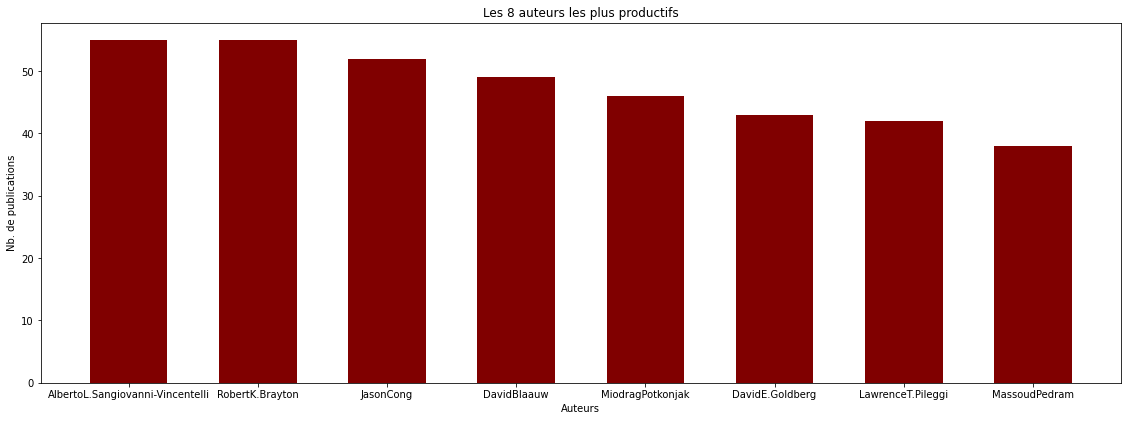

In [ ]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(dict_autors.keys())[:8],list(dict_autors.values())[:8], color="maroon", width = 0.6)
plt.xlabel("Auteurs")
plt.ylabel("Nb. de publications")
plt.title("Les 8 auteurs les plus productifs")
plt.show()

#### ● Les articles les plus populaires (nombre de citations).

In [ ]:
# On crée une colonne 'nb_reference_id' qui calcule le nombre de citation dans reference_id
# Ensuite, on affiche les articles les plus cités.
df=dataset.copy()
df["nb_reference_id"] = dataset["reference_id"].apply(lambda x: len(x))
df_citation=df.sort_values(by=['nb_reference_id'],ascending=False)

df_citation['paper_title'][:5].to_list()

['hundred impossibility result distributed computing',
 'strategic issue problem challenge inductive theorem proving',
 'automatic construction decision tree data multidisciplinary survey',
 'compact localized distributed data structure',
 'review information security issue respective research contribution']

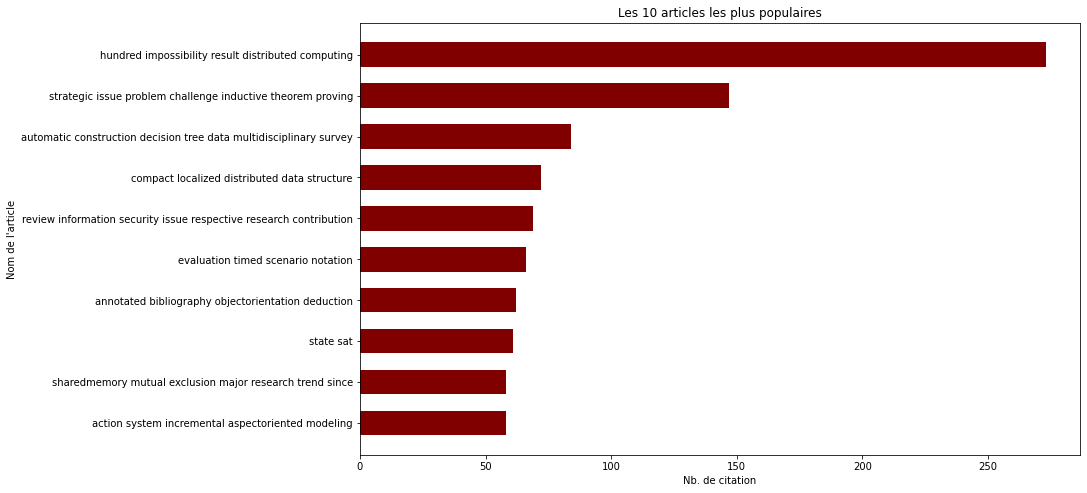

In [ ]:
x = list(reversed(df_citation['paper_title'][:10].to_list()))
y = list(reversed( df_citation['nb_reference_id'][:10].to_list()))
x_pos = [i for i, _ in enumerate(x)]

fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])

plt.barh(x_pos,y, color='maroon', height=0.6)
plt.xlabel("Nb. de citation")
plt.ylabel("Nom de l'article")
plt.title("Les 10 articles les plus populaires")

plt.yticks(x_pos, x)

plt.show()

#### ● Les années avec une grande productivité.

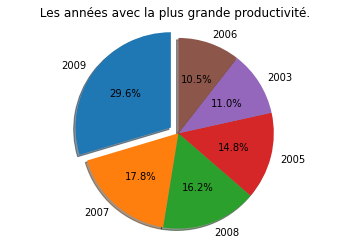

In [ ]:
# ici, on va faire un group by par années, et ordonner notre résultat

years_list=dataset.groupby(['year']).size().sort_values(ascending = False)

explode = (0.1, 0, 0, 0, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(years_list[:6].values, explode=explode, labels=years_list[:6].index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title(" Les années avec la plus grande productivité. ")
plt.show()

#### ● Distribution du nombre d’articles par revue.

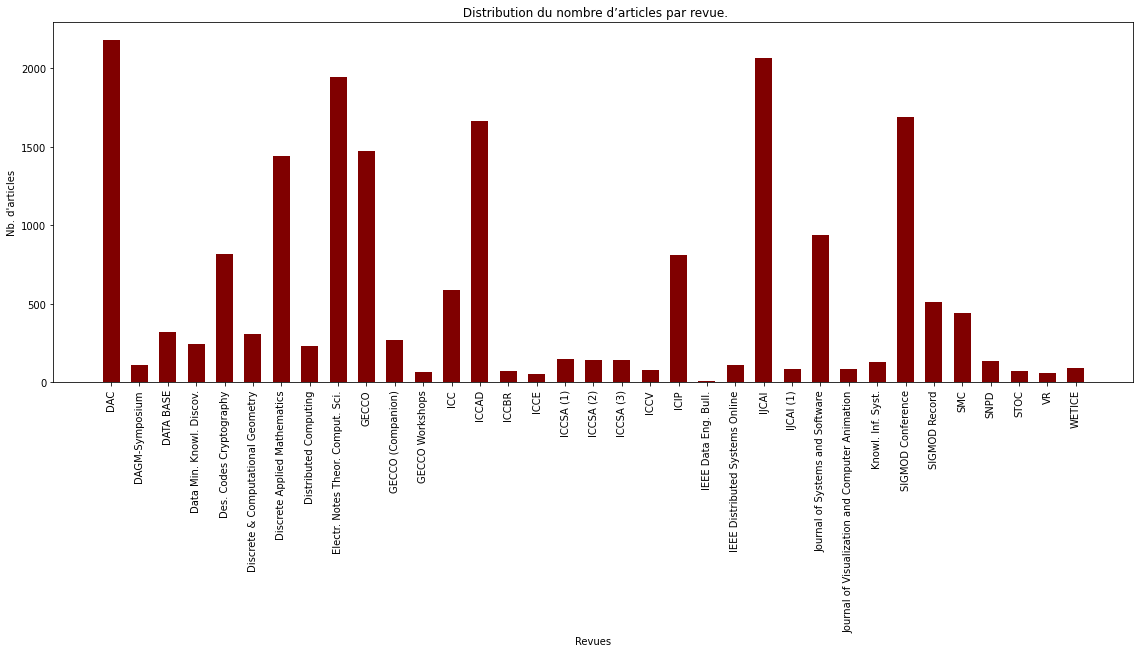

In [ ]:
# ici, on va faire un group by par publication_venue, et afficher la distribution
df=dataset.copy()
revue_list=df.groupby(['publication_venue']).size()

fig = plt.figure(figsize = (15, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(revue_list.index,revue_list.values, color="maroon", width = 0.6)
plt.xlabel("Revues")
plt.ylabel("Nb. d'articles")
plt.xticks(rotation=90)
plt.title(" Distribution du nombre d’articles par revue.")
plt.show()

#### ● Distribution du nombre de citations.

In [ ]:
# nous allons créer une colonne "nb_reference_id" qui compte le nombre de citation pour chaque article

df=dataset.copy()
df["nb_reference_id"] = dataset["reference_id"].apply(lambda x: len(x))


df[:5]

,paper_title,authors,year,publication_venue,paper_index,reference_id,abstract,nb_reference_id
0,improved channel routing via minimization shif...,"[Chung-KuanCheng, DavidN.Deutsch]",1988,DAC,131751,"[133716, 133521, 134343]",channel routing area improvement mean via mini...,3
1,fast simultaneous input vector generation gate...,"[LeiCheng, LiangDeng, DemingChen, MartinD.F.Wong]",2006,DAC,131752,"[132550, 530568, 436486, 134259, 283007, 13442...",input vector control ivc technique based obser...,8
2,overspecification problem sequential atpg algo...,"[Kwang-TingCheng, Hi-KeungTonyMa]",1992,DAC,131756,"[455537, 1078626, 131745]",author show atpg automatic test pattern genera...,3
3,device architecture cooptimization fpga power ...,"[LerongCheng, PhoebeWong, FeiLi, YanLin, LeiHe]",2005,DAC,131759,"[214244, 215701, 214503, 282575, 214411, 21450...",device optimization considering supply voltage...,7
4,differential fault simulation fast method usin...,"[Wu-TungCheng, Meng-LinYu]",1989,DAC,131760,"[131744, 806030]",new fast fault simulator called differential f...,2


In [ ]:
# on crée un dictionnaire où les clés sont le nombre de reference et les valeurs sont le nombre de publications ayant ce nombre de reference reference
dico = {}
for i in df["nb_reference_id"]:
  if i in dico :
      dico[i]=dico[i]+1
  else:
      dico[i]=1

dico=dict(sorted(dico.items(), key=lambda item: item[1],reverse=False))

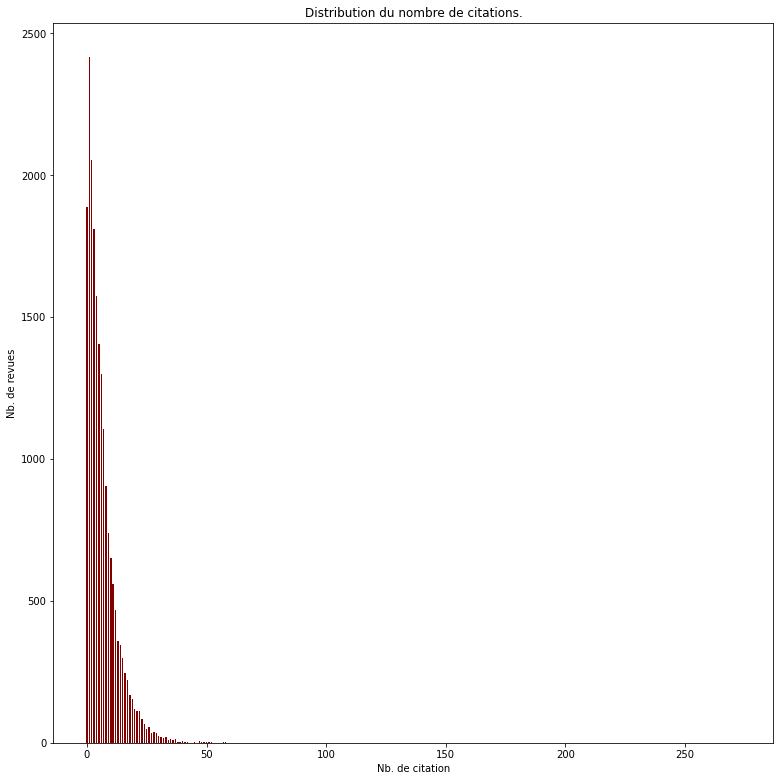

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(list(dico.keys()),list(dico.values()), color="maroon", width = 0.6)
plt.xlabel("Nb. de citation")
plt.ylabel("Nb. de revues")
plt.title("Distribution du nombre de citations.")
plt.show()


#### ● Les termes les plus utilisés.

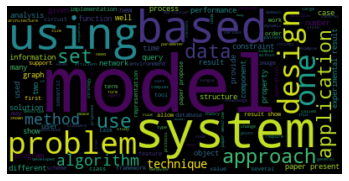

In [ ]:
from wordcloud import WordCloud

abstract_joined= " ".join(review for review in dataset["abstract"])

wordcloud=WordCloud().generate(abstract_joined)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### ● Les articles avec le plus grand nombre de contributeurs (nombre d'auteurs)

.

In [ ]:
# On crée une colonne 'nb_authors' qui calcule le nombre d'auteur 
# Ensuite, on affiche les articles qui le plus grand nombre de contributeur.
df=dataset.copy()
df["nb_authors"] = df["authors"].apply(lambda x: len(x))
df=df.sort_values(by=['nb_authors'],ascending=False)

df['paper_title'][:5].to_list()

['feasibility onchip interconnection using antenna',
 'claremont report database research',
 'simplifying construction complex workflow nonexpert user southern california earthquake center community modeling environment',
 'data web management research politecnico di milano',
 'onchip interconnectaware design modeling methodology based high bandwidth transmission line device']

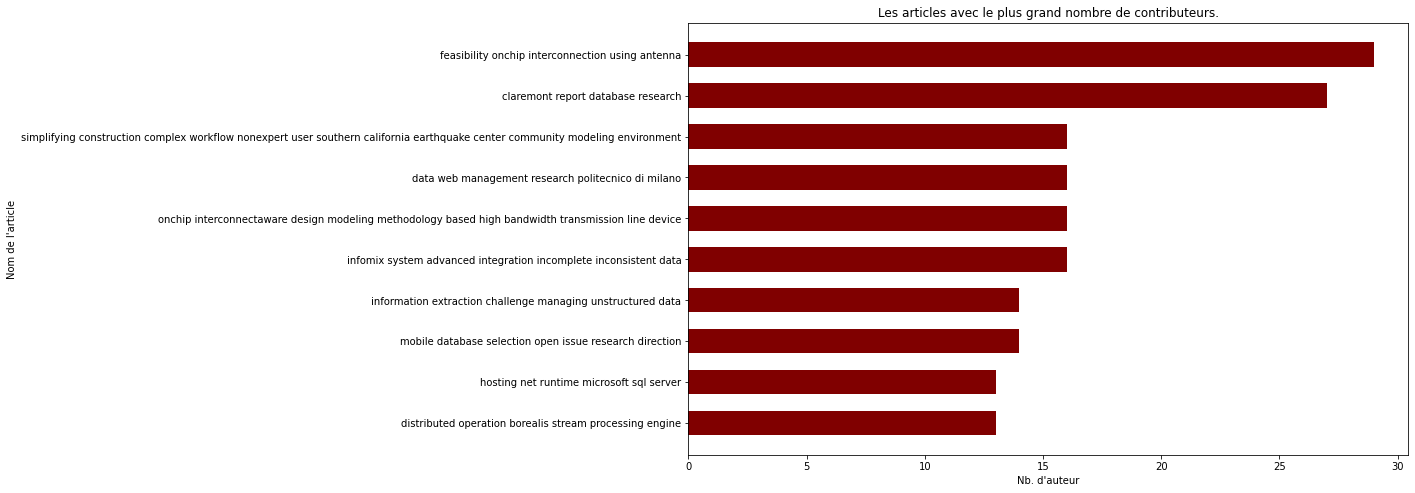

In [ ]:
x = list(reversed(df['paper_title'][:10].to_list()))
y = list(reversed( df['nb_authors'][:10].to_list()))
x_pos = [i for i, _ in enumerate(x)]

fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])

plt.barh(x_pos,y, color='maroon', height=0.6)
plt.xlabel("Nb. d'auteur")
plt.ylabel("Nom de l'article")
plt.title("Les articles avec le plus grand nombre de contributeurs.")

plt.yticks(x_pos, x)

plt.show()

# **Partie 3. Classification non supervisée (Clustering)**

### 8) Application de K-means avec un nombre de classes choisi sur la matrice documents-termes et documents-entités 

* Choix du nombre de classes avec la méthode des coudes

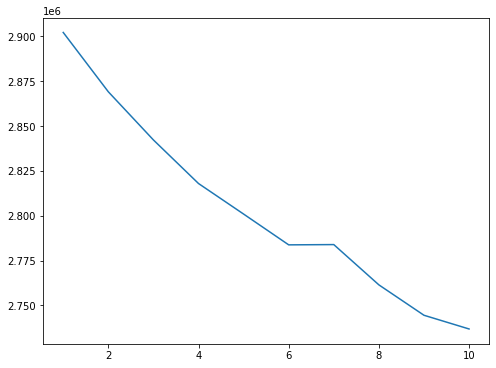

In [ ]:
from sklearn.cluster import KMeans

clusters = range(1,11)
inertia = []
for n in clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(matrice_documents_termes)
    inertia.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(clusters, inertia);
plt.show()

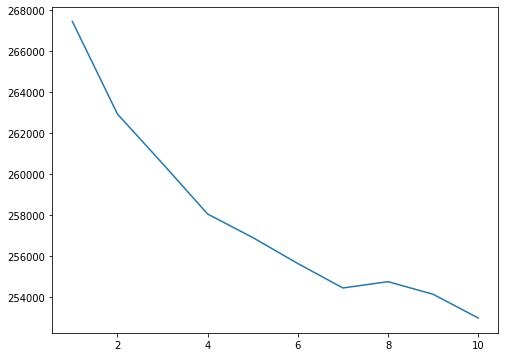

In [ ]:
clusters = range(1,11)
inertia = []
for n in clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(matrice_documents_entites)
    inertia.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(clusters, inertia);
plt.show()

On va prendre 7 clusters.

In [ ]:
k = 7

* Application de Kmeans sur ...

La matrice documents-termes

In [ ]:
kmeans_terms = KMeans(n_clusters=k, random_state=0).fit(matrice_documents_termes)
pred_kmeans_terms = kmeans_terms.labels_

La matrice documents-entités

In [ ]:
kmeans_entites = KMeans(n_clusters=k, random_state=0).fit(matrice_documents_entites)
pred_kmeans_entites = kmeans_entites.labels_

*   Visualisation des clusters

In [ ]:
# compression des matrices pour la visualisation des clusters 
from sklearn.decomposition import TruncatedSVD
clf = TruncatedSVD(100)
pca_terms = clf.fit_transform(matrice_documents_termes)
pca_entites = clf.fit_transform(matrice_documents_entites)

In [ ]:
# visualisation des clusters
def visualise_cluster(name, pca, label, nb_clusters):

  colors = ['red', 'blue', 'green', 'cyan', 'orange', 'yellow', 'brown', 'pink', 'grey', 'black']

  plt.figure(1,figsize=(8,8)) 

  for i in range(nb_clusters):
    plt.scatter(pca[label == i, 0], pca[label == i, 1], s = 50, c = colors[i], label = 'Cluster' + str(i))

  plt.title('Clusters of documents by ' + name)
  plt.xlabel('C1')
  plt.ylabel('C2')
  plt.legend()
  plt.show()

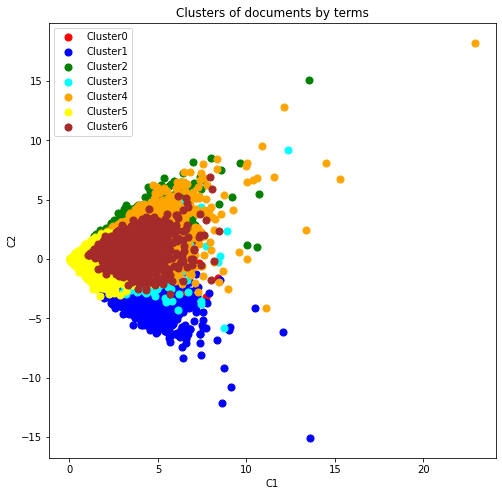

In [ ]:
visualise_cluster('terms', pca_terms, pred_kmeans_terms, k)

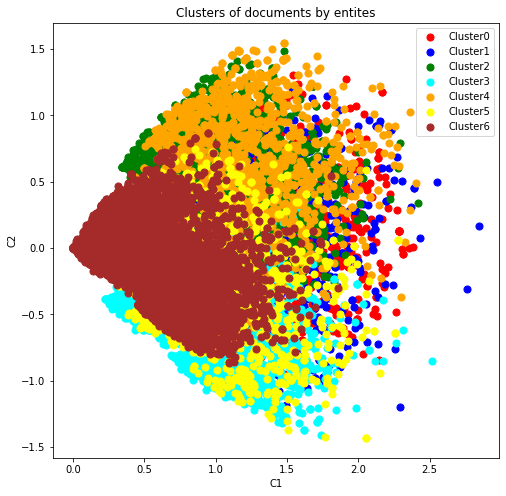

In [ ]:
visualise_cluster('entites', pca_entites, pred_kmeans_entites, k)

### 9) Interprétation des classes (clusters) obtenues

* Les termes les plus fréquents pour chaque cluster

In [ ]:
# affichage des termes les plus fréquents dans chaque cluster
def cluster_terms_frequency(label, n_cluster,N_max):
  matrix = matrice_documents_termes[np.where(label == n_cluster)[0]].sum(axis=0)
  array = np.array(matrix)[0]
  indices = (-array).argsort()[:N_max]
  df = pd.DataFrame(columns=["term", "frequency"])
  for i in indices:
    df = df.append({"term" : cv.get_feature_names_out()[i], "frequency" : array[i]}, ignore_index=True)
  return df

In [ ]:
df_list = []
df_list_labels = []
for cluster in range(k):
  df_list_labels.append(f"Cluster {cluster}")
  df_list.append(cluster_terms_frequency(pred_kmeans_terms, cluster, N_max=10))
    
pd.concat(df_list, keys=df_list_labels, axis=1)

Cluster 0            Cluster 1  ... Cluster 5 Cluster 6          
        term frequency       term  ... frequency      term frequency
0     method      3709  algorithm  ...      5510     model      5051
1      image      2450    problem  ...      3561     paper       892
2      paper      1098      graph  ...      3043    system       845
3   proposed      1063      paper  ...      2906     based       636
4     result      1021     result  ...      2885  approach       627
5      based       940       time  ...      2843   problem       550
6   approach       907   solution  ...      2659     using       527
7      using       878        set  ...      2515    result       505
8  algorithm       878       show  ...      2493    method       504
9    feature       685     number  ...      2344      data       501

[10 rows x 14 columns]

*   Les entités les plus fréquentes pour chaque cluster

In [ ]:
# affichage des entités les plus fréquentes dans chaque cluster
def cluster_entites_frequency(label, n_cluster,N_max):
  matrix = matrice_documents_entites[np.where(label == n_cluster)[0]].sum(axis=0)
  array = np.array(matrix)[0]
  indices = (-array).argsort()[:N_max]

  df = pd.DataFrame(columns=["entite", "frequency"])
  for i in indices:
    df = df.append({"entite" : dictEntityIdLabel.get(dictIndexEntiteId.get(i)), "frequency" : array[i]}, ignore_index=True)
  return df

In [ ]:
df_list = []
df_list_labels = []
for cluster in range(k):
  df_list_labels.append(f"Cluster {cluster}")
  df_list.append(cluster_entites_frequency(pred_kmeans_entites, cluster, N_max=10))
    
pd.concat(df_list, keys=df_list_labels, axis=1)

Cluster 0            ...           Cluster 6          
               entite frequency  ...              entite frequency
0               means    2440.0  ...               paper    2237.0
1               paper     919.0  ...              result    1004.0
2           algorithm     754.0  ...                task     953.0
3              result     614.0  ...  mathematical model     913.0
4          subroutine     601.0  ...          subroutine     889.0
5                task     578.0  ...              number     725.0
6  mathematical model     413.0  ...                data     713.0
7                data     413.0  ...         application     658.0
8                work     301.0  ...            graffiti     596.0
9         application     298.0  ...                work     544.0

[10 rows x 14 columns]

On remarque que plusieurs mots/entités apparaissent dans plusieurs clusters (algorithm, paper, result, problem, approach, etc). Cela peut s'expliquer par le fait que nos documents sont tous des articles du domaine informatique (voir [dblp](https://dblp.org/) ). 
Toutefois, en étudiant un nombre plus important des mots/entités fréquents dans les clusetrs, on observe également la présence de mots particuliers à certains clusters. 

* Le type de revues pour chaque cluster

In [ ]:
dataset['pred_kmeans'] = pd.DataFrame(pred_kmeans_terms)
liste = dataset.groupby(['pred_kmeans'])['publication_venue'].apply(lambda x: list(np.unique(x)))

df_list = []
df_list_labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6"]

for ligne in liste:
    df = pd.DataFrame(columns=["type_de_revue"])
    for publication_venue in ligne:
        df = df.append({"type_de_revue" : publication_venue}, ignore_index=True)
    df_list.append(df)

pd.concat(df_list, keys=df_list_labels, axis=1).fillna("")

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
,type_de_revue,type_de_revue,type_de_revue,type_de_revue,type_de_revue,type_de_revue,type_de_revue
0,DAC,DAC,DAC,DAC,DAC,DAC,DAC
1,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium,DATA BASE,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium
2,DATA BASE,DATA BASE,DATA BASE,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,DATA BASE,DATA BASE
3,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Des. Codes Cryptography,Des. Codes Cryptography,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.
4,Des. Codes Cryptography,Des. Codes Cryptography,Des. Codes Cryptography,Discrete & Computational Geometry,Discrete & Computational Geometry,Des. Codes Cryptography,Des. Codes Cryptography
5,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete & Computational Geometry,Discrete & Computational Geometry
6,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete Applied Mathematics,Distributed Computing,Electr. Notes Theor. Comput. Sci.,Discrete Applied Mathematics,Discrete Applied Mathematics
7,Distributed Computing,Distributed Computing,Distributed Computing,Electr. Notes Theor. Comput. Sci.,GECCO,Distributed Computing,Distributed Computing
8,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,GECCO,GECCO (Companion),Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.


Les articles ont été publiés au total dans 35 revues. La plupart d'entre eux réapparaisse dans chaque cluster (entre 26 et 32 revues).

* Évolution des clusters selon le temps (les années)

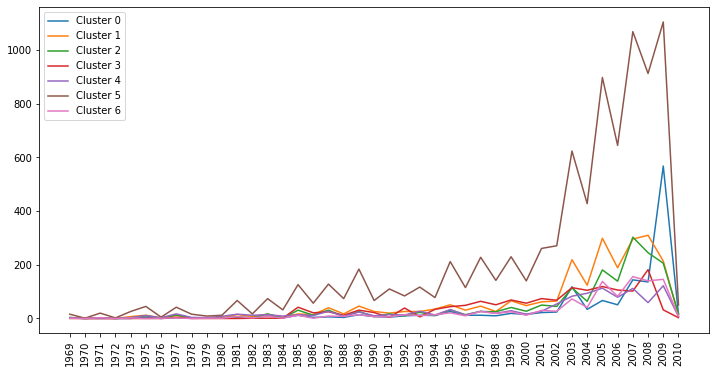

In [ ]:
df = dataset.groupby(['pred_kmeans','year']).size()
df = df.unstack().fillna(0.0)

fig = plt.figure(figsize=(12, 6))

for i in range(df.shape[0]):
    plt.plot(df.columns, df.iloc[i], label = f"Cluster {i}")
    plt.xticks(rotation=90)
    
plt.legend()
plt.show()

Au cours du temps, le nombre d'articles pour chaque cluster a augmenté significativement. On remarque que le cluster 5 se démarque des autres par sa croissance en nombre d'articles depuis ses 10 dernières années. Il est suivi ensuite par la cluster 0. Les autres clusters sont soient stagnants ou décroissance. 
Il y a de nombreux pics dans le graphe, ce qui signifie que le nombre d'articles dans chaque cluster est instable.

  

*  Analyse des clusters selon le nombre de citations des articles contenus dans chaque
cluster

In [ ]:
# nombre de citations dans chaque cluster
liste = dataset.groupby(['pred_kmeans'])['reference_id'].apply(lambda x: len(np.unique(sum(x, []))))
i = 0
for ligne in liste:
    print(f"Cluster {i} : {ligne}")
    i = i + 1

Cluster 0 : 7264
Cluster 1 : 12136
Cluster 2 : 9574
Cluster 3 : 6189
Cluster 4 : 7230
Cluster 5 : 34053
Cluster 6 : 5863


Le cluster 5 a le plus grand nombre de citations, ce qui s'explique par son nombre important d'articles. Les citations dans chaque cluster est proportionnel au nombre d'articles.

### 10) Analyse cette fois avec le Spherical K-means.

In [ ]:
from soyclustering import SphericalKMeans

pred_spherical_kmeans_terms = SphericalKMeans(k).fit_predict(matrice_documents_termes)
pred_spherical_kmeans_entites = SphericalKMeans(k).fit_predict(matrice_documents_entites)

*   Visualisation des clusters

In [ ]:
# compression des matrices pour la visualisation
clf = TruncatedSVD(100)
pca_terms = clf.fit_transform(matrice_documents_termes)
pca_entites = clf.fit_transform(matrice_documents_entites)

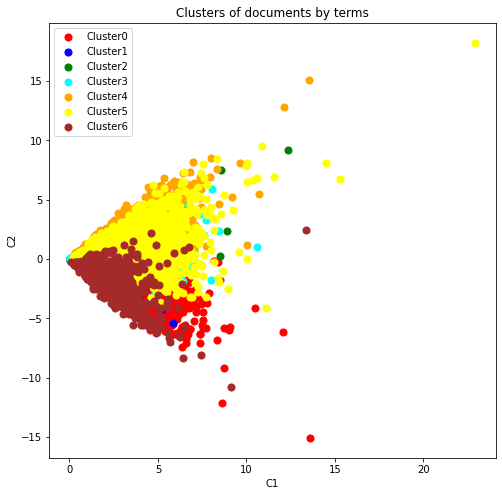

In [ ]:
visualise_cluster('terms', pca_terms, pred_spherical_kmeans_terms, k)

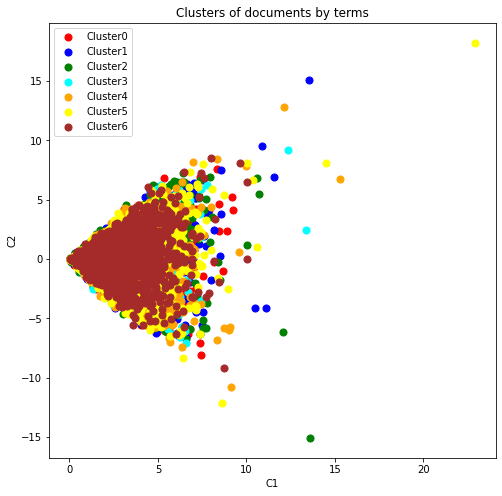

In [ ]:
visualise_cluster('terms', pca_terms, pred_spherical_kmeans_entites, k)

* Les termes les plus fréquents pour chaque cluster

In [ ]:
df_list = []
df_list_labels = []
for cluster in range(k):
  df_list_labels.append(f"Cluster {cluster}")
  df_list.append(cluster_terms_frequency(pred_spherical_kmeans_terms, cluster, N_max=10))
    
pd.concat(df_list, keys=df_list_labels, axis=1)

Cluster 0           Cluster 1  ... Cluster 5  Cluster 6          
        term frequency      term  ... frequency       term frequency
0  algorithm      8204       set  ...      6990      graph      3709
1    problem      7230      code  ...      3276     vertex       970
2      paper      3215  function  ...      3134    problem       711
3     result      2987     paper  ...      2234  algorithm       664
4    circuit      2430    result  ...      2225     number       643
5     method      2333      show  ...      2072        set       580
6   approach      2318    number  ...      2016       edge       514
7   solution      2227      also  ...      1865      paper       434
8       time      2210     bound  ...      1746     result       393
9       show      2091     point  ...      1589       show       393

[10 rows x 14 columns]

*   Les entités les plus fréquentes pour chaque cluster

In [ ]:
df_list = []
df_list_labels = []
for cluster in range(k):
  df_list_labels.append(f"Cluster {cluster}")
  df_list.append(cluster_entites_frequency(pred_spherical_kmeans_entites, cluster, N_max=10))
    
pd.concat(df_list, keys=df_list_labels, axis=1)

Cluster 0            ...           Cluster 6          
               entite frequency  ...              entite frequency
0               means    2156.0  ...            graffiti     834.0
1               paper     721.0  ...                   G     597.0
2           algorithm     574.0  ...              number     582.0
3          subroutine     468.0  ...  Boltzmann constant     550.0
4                task     443.0  ...              vertex     453.0
5  mathematical model     363.0  ...                task     412.0
6                data     351.0  ...           algorithm     319.0
7         application     275.0  ...         equals sign     312.0
8                time     270.0  ...         letter case     302.0
9              design     257.0  ...               paper     286.0

[10 rows x 14 columns]

On remarque que les mots/entités les plus fréquents dans ces clusters sont  plus variés par rapport aux clusters de Kmeans. En effet, ils sont plus spécifiques aux clusters auxquels ils appartiennent.    

* Le type de revues pour chaque cluster

In [ ]:
dataset['pred_spherical_kmeans'] = pd.DataFrame(pred_spherical_kmeans_terms)
liste = dataset.groupby(['pred_spherical_kmeans'])['publication_venue'].apply(lambda x: list(np.unique(x)))

df_list = []
df_list_labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6"]

for ligne in liste:
    df = pd.DataFrame(columns=["type_de_revue"])
    for publication_venue in ligne:
        df = df.append({"type_de_revue" : publication_venue}, ignore_index=True)
    df_list.append(df)

pd.concat(df_list, keys=df_list_labels, axis=1).fillna("")

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
,type_de_revue,type_de_revue,type_de_revue,type_de_revue,type_de_revue,type_de_revue,type_de_revue
0,DAC,DAC,DAC,DAC,DAC,DAC,DAC
1,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium,DAGM-Symposium
2,DATA BASE,DATA BASE,DATA BASE,DATA BASE,DATA BASE,DATA BASE,DATA BASE
3,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.,Data Min. Knowl. Discov.
4,Des. Codes Cryptography,Des. Codes Cryptography,Des. Codes Cryptography,Des. Codes Cryptography,Des. Codes Cryptography,Des. Codes Cryptography,Des. Codes Cryptography
5,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete & Computational Geometry,Discrete & Computational Geometry
6,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete Applied Mathematics,Discrete Applied Mathematics
7,Distributed Computing,Distributed Computing,Distributed Computing,Distributed Computing,Distributed Computing,Distributed Computing,Distributed Computing
8,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.,Electr. Notes Theor. Comput. Sci.


Le résultat est similaire aux clusters du Kmeans. Dans chaque cluster, on retrouve la majorité des revues.

* Évolution des clusters selon le temps (les années)

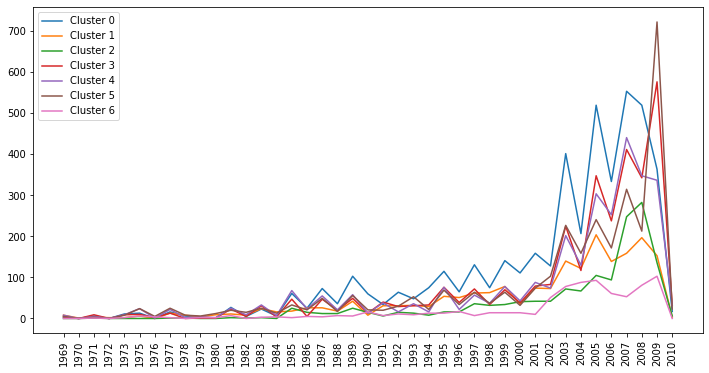

In [ ]:
df = dataset.groupby(['pred_spherical_kmeans','year']).size()
df = df.unstack().fillna(0.0)

fig = plt.figure(figsize=(12, 6))

for i in range(df.shape[0]):
    plt.plot(df.columns, df.iloc[i], label = f"Cluster {i}")
    plt.xticks(rotation=90)
    
plt.legend()
plt.show()

Il n'y a pas de clusters qui se démarquent par le nombre d'articles. Les clusters sont mieux distribués que ceux de Kmeans.

*  Analyse des clusters selon le nombre de citations des articles contenus dans chaque
cluster

In [ ]:
# nombre de citations dans chaque cluster
dataset.groupby(['pred_spherical_kmeans'])['reference_id'].apply(lambda x: len(np.unique(sum(x, []))))

pred_spherical_kmeans
0.0    18129
1.0     9852
2.0     7595
3.0    15622
4.0    14739
5.0    15683
6.0     5027
Name: reference_id, dtype: int64

On observe que les clusters formés par Kmeans sphériques sont mieux distribués et que les termes les plus fréquents sont plus spécifiques aux clusters.

On peut conclure que la technique Kmeans spéhrique a de meilleurs résultats pour le clustering de textes que Kmeans.
Toutefois, le modèle a ses limites car on n'arrive toujours pas à bien décrire la frontière entre chaque cluster.

In [33]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Cours/M2/Analyse de texte/projet.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
[NbConvertApp] Converting notebook /content/drive/MyDrive/Cours/M2/Analyse de texte/projet.ipynb to PDF
[NbConvertApp] Support files will be in projet_files/
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConvertApp] Making directory ./projet_files
[NbConve